#### Chapter 12: Simulation and Valuation in General Model Framework


##### Simulation with Monte Carlo 

* efficient and flexible method to evaluate financial models and derivative pricing formulas
* You must forst discretize the the Stochastic Differential Equations that govern the components of the model
* Overall model is based on short rate and volatility and those components must be discretized and modeled

##### Variance reduction techniques

* Control variates
* Moment matching
* Antithetic paths
* Importance sampling

* Moment matching and antithetic paths are generic variance reduction techniques
* Control variates are unique to the specific problem you are trying to calibrate

* Simulate via MCS the following
    * Short rates
    * Implied volatilities
    * Index Levels
    
##### Equity option valuation

* European options
* Systematic bias to overprice the options
* Adding more paths/simulations does not improve the estimates
* Increasing the time steps for each run does
* Increasing the time steps reduces the error in the negative and positive direction
* Since time step increase is so important, Euler discretization is necessary to achieve the accuracy for complex models

* American options (with early exercise) 
* Early exercise premium for American put options vs. European (longer maturity exercise)
* Early excercise premium with an increase in time-to-maturity

In [4]:
#
# Monte Carlo Simulation of BCC97 Model
# 12_val/BCC97_simulation.py
#
# (c) Dr. Yves J. Hilpisch
# Derivatives Analytics with Python
#
import sys
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
sys.path.append('11_cal')
from H93_calibration import S0, kappa_r, theta_r, sigma_r, r0
from pylab import plt
plt.style.use('seaborn')
%matplotlib inline

mpl.rcParams['font.family'] = 'serif'
#
# Model Parameters
#
opt = np.load('11_cal/opt_full.npy')
kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta = opt


#
# Simulation Parameters
#
T = 1.0  # time horizon
M = 25  # time steps
I = 10000  # number of replications per valuation
anti_paths = True  # antithetic paths for variance reduction
moment_matching = True  # moment matching for variance reduction
np.random.seed(100000)  # seed value for random number generator

#
# Random Number Generation
#


def generate_cholesky(rho):
    ''' Function to generate Cholesky matrix.

    Parameters
    ==========
    rho: float
        correlation between index level and variance

    Returns
    =======
    matrix: NumPy array
        Cholesky matrix
    '''
    rho_rs = 0  # correlation between index level and short rate
    covariance = np.zeros((4, 4), dtype=np.float)
    covariance[0] = [1.0, rho_rs, 0.0, 0.0]
    covariance[1] = [rho_rs, 1.0, rho, 0.0]
    covariance[2] = [0.0, rho, 1.0, 0.0]
    covariance[3] = [0.0, 0.0, 0.0, 1.0]
    cho_matrix = np.linalg.cholesky(covariance)
    return cho_matrix


def random_number_generator(M, I, anti_paths, moment_matching):
    ''' Function to generate pseudo-random numbers.

    Parameters
    ==========
    M: int
        time steps
    I: int
        number of simulation paths
    anti_paths: bool
        flag for antithetic paths
    moment_matching: bool
        flag for moment matching

    Returns
    =======
    rand: NumPy array
        random number array
    '''
    if anti_paths:
        rand = np.random.standard_normal((4, M + 1, int(I / 2)))
        rand = np.concatenate((rand, -rand), 2)
    else:
        rand = np.random.standard_normal((4, M + 1, I))
    if moment_matching:
        for a in range(4):
            rand[a] = rand[a] / np.std(rand[a])
            rand[a] = rand[a] - np.mean(rand[a])
    return rand

#
# Function for Short Rate and Volatility Processes
#


def SRD_generate_paths(x0, kappa, theta, sigma, T, M, I,
                       rand, row, cho_matrix):
    ''' Function to simulate Square-Root Difussion (SRD/CIR) process.

    Parameters
    ==========
    x0: float
        initial value
    kappa: float
        mean-reversion factor
    theta: float
        long-run mean
    sigma: float
        volatility factor
    T: float
        final date/time horizon
    M: int
        number of time steps
    I: int
        number of paths
    row: int
        row number for random numbers
    cho_matrix: NumPy array
        cholesky matrix

    Returns
    =======
    x: NumPy array
        simulated variance paths
    '''
    dt = T / M
    x = np.zeros((M + 1, I), dtype=np.float)
    x[0] = x0
    xh = np.zeros_like(x)
    xh[0] = x0
    sdt = math.sqrt(dt)
    for t in range(1, M + 1):
        ran = np.dot(cho_matrix, rand[:, t])
        xh[t] = (xh[t - 1] + kappa * (theta -
                                      np.maximum(0, xh[t - 1])) * dt +
                 np.sqrt(np.maximum(0, xh[t - 1])) * sigma * ran[row] * sdt)
        x[t] = np.maximum(0, xh[t])
    return x

#
# Function for B96 Index Process
#


def B96_generate_paths(S0, r, v, lamb, mu, delta, rand, row1, row2,
                       cho_matrix, T, M, I, moment_matching):
    ''' Simulation of Bates (1996) index process.

    Parameters
    ==========
    S0: float
        initial value
    r: NumPy array
        simulated short rate paths
    v: NumPy array
        simulated variance paths
    lamb: float
        jump intensity
    mu: float
        expected jump size
    delta: float
        standard deviation of jump
    rand: NumPy array
        random number array
    row1, row2: int
        rows/matrices of random number array to use
    cho_matrix: NumPy array
        Cholesky matrix
    T: float
        time horizon, maturity
    M: int
        number of time intervals, steps
    I: int
        number of paths to simulate
    moment_matching: bool
        flag for moment matching

    Returns
    =======
    S: NumPy array
        simulated index level paths
    '''
    S = np.zeros((M + 1, I), dtype=np.float)
    S[0] = S0
    dt = T / M
    sdt = math.sqrt(dt)
    ranp = np.random.poisson(lamb * dt, (M + 1, I))
    bias = 0.0
    for t in range(1, M + 1, 1):
        ran = np.dot(cho_matrix, rand[:, t, :])
        if moment_matching:
            bias = np.mean(np.sqrt(v[t]) * ran[row1] * sdt)
        S[t] = S[t - 1] * (np.exp(((r[t] + r[t - 1]) / 2 - 0.5 * v[t]) * dt +
                                  np.sqrt(v[t]) * ran[row1] * sdt - bias) +
                           (np.exp(mu + delta * ran[row2]) - 1) * ranp[t])
    return S


if __name__ == '__main__':
    #
    # Simulation
    #
    cho_matrix = generate_cholesky(rho)
    rand = random_number_generator(M, I, anti_paths, moment_matching)
    r = SRD_generate_paths(r0, kappa_r, theta_r, sigma_r, T, M, I,
                           rand, 0, cho_matrix)
    v = SRD_generate_paths(v0, kappa_v, theta_v, sigma_v, T, M, I,
                           rand, 2, cho_matrix)
    S = B96_generate_paths(S0, r, v, lamb, mu, delta, rand, 1, 3,
                           cho_matrix, T, M, I, moment_matching)


def plot_rate_paths(r):
    plt.figure(figsize=(10, 6))
    plt.plot(r[:, :10])
    plt.xlabel('time step')
    plt.ylabel('short rate level')
    plt.title('Short Rate Simulated Paths')


def plot_volatility_paths(v):
    plt.figure(figsize=(10, 6))
    plt.plot(np.sqrt(v[:, :10]))
    plt.xlabel('time step')
    plt.ylabel('volatility level')
    plt.title('Volatility Simulated Paths')


def plot_index_paths(S):
    plt.figure(figsize=(10, 6))
    plt.plot(S[:, :10])
    plt.xlabel('time step')
    plt.ylabel('index level')
    plt.title('EURO STOXX 50 Simulated Paths')


def plot_index_histogram(S):
    plt.figure(figsize=(10, 6))
    plt.hist(S[-1], bins=30)
    plt.xlabel('index level')
    plt.ylabel('frequency')
    plt.title('EURO STOXX 50 Values after 1 Year')


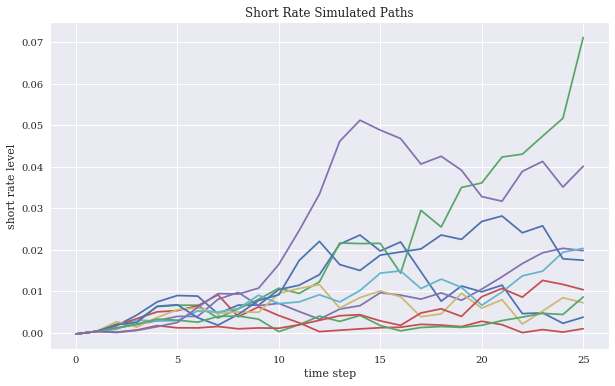

In [5]:
plot_rate_paths(r)

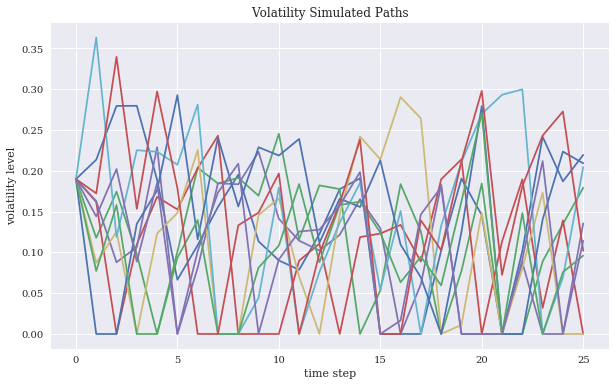

In [6]:
plot_volatility_paths(v)

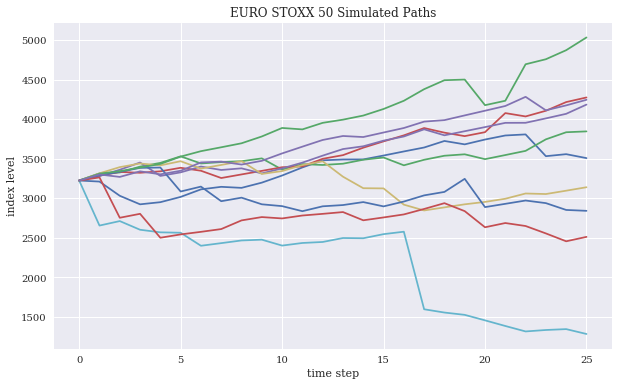

In [7]:
plot_index_paths(S)


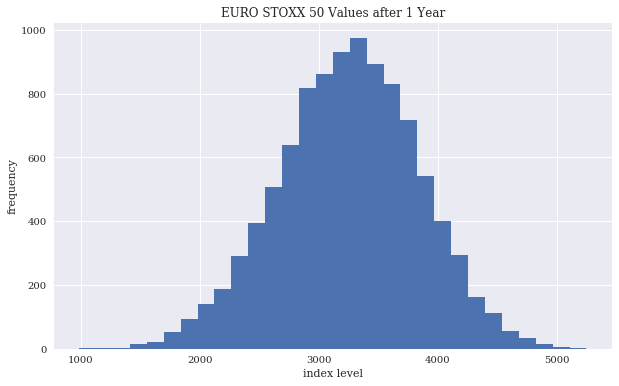

In [8]:
plot_index_histogram(S)


In [10]:
%run 12_val/BCC97_valuation_comparison.py

## European Option Valuation
* Simulate end of period index levels and calculate MCS estimator as:
    * $C_0^{MCS}$ = $B_0(T) \frac {1}{I} \sum\limits_{i=1}^I max[S_{T,i} - K, 0]$
* Short rate and volatility are estimated via Square Root Diffusion process

##### We have large positive errors errors 

In [11]:
%time compare_values(M0=50, I=50000)

      T |      K |      C0 |     MCS |    DIFF
  0.083 |   3050 | 193.692 | 195.584 |   1.892
  0.083 |   3225 |  62.147 |  64.162 |   2.016
  0.083 |   3400 |   1.967 |   2.544 |   0.577
  0.500 |   3050 | 259.126 | 272.960 |  13.834
  0.500 |   3225 | 146.891 | 164.333 |  17.443
  0.500 |   3400 |  67.142 |  85.330 |  18.188
  1.000 |   3050 | 321.419 | 344.280 |  22.861
  1.000 |   3225 | 216.227 | 243.415 |  27.188
  1.000 |   3400 | 133.950 | 162.403 |  28.453
  1.500 |   3050 | 378.978 | 407.035 |  28.057
  1.500 |   3225 | 276.942 | 309.251 |  32.309
  1.500 |   3400 | 193.333 | 227.887 |  34.554
  2.000 |   3050 | 435.337 | 470.659 |  35.322
  2.000 |   3225 | 335.010 | 374.315 |  39.305
  2.000 |   3400 | 250.314 | 291.888 |  41.574
  3.000 |   3050 | 549.127 | 594.413 |  45.287
  3.000 |   3225 | 450.522 | 499.873 |  49.350
  3.000 |   3400 | 364.049 | 416.300 |  52.252
CPU times: user 6.54 s, sys: 611 ms, total: 7.15 s
Wall time: 4.41 s


##### We have large positive errors errors. Increasing the number of runs does not help

In [12]:
%time compare_values(M0=50, I=200000)

      T |      K |      C0 |     MCS |    DIFF
  0.083 |   3050 | 193.692 | 195.870 |   2.178
  0.083 |   3225 |  62.147 |  64.609 |   2.462
  0.083 |   3400 |   1.967 |   2.606 |   0.639
  0.500 |   3050 | 259.126 | 273.046 |  13.920
  0.500 |   3225 | 146.891 | 164.698 |  17.807
  0.500 |   3400 |  67.142 |  85.852 |  18.710
  1.000 |   3050 | 321.419 | 342.696 |  21.277
  1.000 |   3225 | 216.227 | 241.375 |  25.148
  1.000 |   3400 | 133.950 | 160.706 |  26.756
  1.500 |   3050 | 378.978 | 407.341 |  28.363
  1.500 |   3225 | 276.942 | 309.124 |  32.182
  1.500 |   3400 | 193.333 | 227.473 |  34.140
  2.000 |   3050 | 435.337 | 470.323 |  34.986
  2.000 |   3225 | 335.010 | 373.940 |  38.930
  2.000 |   3400 | 250.314 | 291.583 |  41.268
  3.000 |   3050 | 549.127 | 597.571 |  48.444
  3.000 |   3225 | 450.522 | 503.362 |  52.840
  3.000 |   3400 | 364.049 | 420.019 |  55.970
CPU times: user 24.5 s, sys: 4.65 s, total: 29.1 s
Wall time: 20.4 s


##### Increasing the number of time steps M does
* Error reduction and also positive and negative errors clos to 0

In [13]:
%time compare_values(M0=200, I=50000)

      T |      K |      C0 |     MCS |    DIFF
  0.083 |   3050 | 193.692 | 193.241 |  -0.450
  0.083 |   3225 |  62.147 |  61.595 |  -0.552
  0.083 |   3400 |   1.967 |   2.581 |   0.614
  0.500 |   3050 | 259.126 | 259.140 |   0.014
  0.500 |   3225 | 146.891 | 149.090 |   2.199
  0.500 |   3400 |  67.142 |  71.122 |   3.980
  1.000 |   3050 | 321.419 | 322.117 |   0.697
  1.000 |   3225 | 216.227 | 219.528 |   3.301
  1.000 |   3400 | 133.950 | 139.285 |   5.335
  1.500 |   3050 | 378.978 | 377.499 |  -1.479
  1.500 |   3225 | 276.942 | 278.276 |   1.334
  1.500 |   3400 | 193.333 | 197.137 |   3.804
  2.000 |   3050 | 435.337 | 435.067 |  -0.270
  2.000 |   3225 | 335.010 | 337.597 |   2.587
  2.000 |   3400 | 250.314 | 255.541 |   5.227
  3.000 |   3050 | 549.127 | 552.842 |   3.715
  3.000 |   3225 | 450.522 | 457.774 |   7.252
  3.000 |   3400 | 364.049 | 374.340 |  10.291
CPU times: user 23.8 s, sys: 4.26 s, total: 28.1 s
Wall time: 20.6 s


In [14]:
#
# Valuation of American Options in BCC97 Model
# by Least-Squares Monte Carlo Algorithm
# 12_val/BCC97_american_valuation.py
#
# (c) Dr. Yves J. Hilpisch
# Derivatives Analytics with Python
#
import sys

sys.path.extend(['09_gmm', '10_mcs'])
from BCC_option_valuation import *
from CIR_zcb_valuation_gen import B
from BCC97_simulation import *

#
# Additional Parameters
#
D = 10  # number of basis functions
t_list = [1 / 12., 0.5, 1.0, 1.5, 2.0, 3.0]
k_list = [3050, 3225, 3400]

#
# LSM Valuation Function
#


def BCC97_lsm_valuation(S, r, v, K, T, M, I):
    ''' Function to value American put options by LSM algorithm.

    Parameters
    ==========
    S: NumPy array
        simulated index level paths
    r: NumPy array
        simulated short rate paths
    v: NumPy array
        simulated variance paths
    K: float
        strike of the put option
    T: float
        final date/time horizon
    M: int
        number of time steps
    I: int
        number of paths

    Returns
    =======
    LSM_value: float
        LSM Monte Carlo estimator of American put option value
    '''
    dt = T / M
    # inner value matrix
    h = np.maximum(K - S, 0)
    # value/cash flow matrix
    V = np.maximum(K - S, 0)
    for t in range(M - 1, 0, -1):
        df = np.exp(-(r[t] + r[t + 1]) / 2 * dt)
        # select only ITM paths
        itm = np.greater(h[t], 0)
        relevant = np.nonzero(itm)
        rel_S = np.compress(itm, S[t])
        no_itm = len(rel_S)
        if no_itm == 0:
            cv = np.zeros((I), dtype=np.float)
        else:
            rel_v = np.compress(itm, v[t])
            rel_r = np.compress(itm, r[t])
            rel_V = (np.compress(itm, V[t + 1]) *
                     np.compress(itm, df))
            matrix = np.zeros((D + 1, no_itm), dtype=np.float)
            matrix[10] = rel_S * rel_v * rel_r
            matrix[9] = rel_S * rel_v
            matrix[8] = rel_S * rel_r
            matrix[7] = rel_v * rel_r
            matrix[6] = rel_S ** 2
            matrix[5] = rel_v ** 2
            matrix[4] = rel_r ** 2
            matrix[3] = rel_S
            matrix[2] = rel_v
            matrix[1] = rel_r
            matrix[0] = 1
            reg = np.linalg.lstsq(matrix.transpose(), rel_V)
            cv = np.dot(reg[0], matrix)
        erg = np.zeros((I), dtype=np.float)
        np.put(erg, relevant, cv)
        V[t] = np.where(h[t] > erg, h[t], V[t + 1] * df)
        # exercise decision
    df = np.exp(-((r[0] + r[1]) / 2) * dt)
    LSM_value = max(np.sum(V[1, :] * df) / I, h[0, 0])   # LSM estimator
    return LSM_value

#
# Valuation for Different Strikes & Maturities
#


def lsm_compare_values(M0=50, I=50000):
    results = []
    for T in t_list:
        #
        # Simulation
        #
        M = int(M0 * T)
        cho_matrix = generate_cholesky(rho)
        rand = random_number_generator(M, I, anti_paths, moment_matching)
        r = SRD_generate_paths(r0, kappa_r, theta_r, sigma_r, T, M, I,
                               rand, 0, cho_matrix)
        v = SRD_generate_paths(v0, kappa_v, theta_v, sigma_v, T, M, I,
                               rand, 2, cho_matrix)
        S = B96_generate_paths(S0, r, v, lamb, mu, delta, rand, 1, 3,
                               cho_matrix, T, M, I, moment_matching)
        for K in k_list:
            #
            # Valuation
            #
            B0T = B([r0, kappa_r, theta_r, sigma_r, 0.0, T])
            V0_lsm = BCC97_lsm_valuation(S, r, v, K, T, M, I)
            # LSM estimator
            #
            # European Call Option via Fourier
            #
            ra = -math.log(B0T) / T  # average short rate/yield
            C0 = BCC_call_value(S0, K, T, ra, kappa_v, theta_v, sigma_v,
                                rho, v0, lamb, mu, delta)
            P0 = C0 + K * B0T - S0

            results.append((T, K, P0, V0_lsm, V0_lsm - P0))

    print(" %6s | %6s | %7s | %7s | %7s" % ('T', 'K', 'P0', 'LSM', 'DIFF'))
    for res in results:
        print(" %6.3f | %6d | %7.3f | %7.3f | %7.3f" % res)

        

##### American Options
* We simulate the early exercise component
* This results in higher prices for American options the further out in the term structure


In [15]:
%time lsm_compare_values(M0=150, I=50000)

      T |      K |      P0 |     LSM |    DIFF
  0.083 |   3050 |  17.681 |  17.431 |  -0.250
  0.083 |   3225 |  61.131 |  61.001 |  -0.130
  0.083 |   3400 | 175.947 | 181.570 |   5.624
  0.500 |   3050 |  77.963 |  84.277 |   6.314
  0.500 |   3225 | 140.428 | 149.270 |   8.842
  0.500 |   3400 | 235.379 | 246.148 |  10.769
  1.000 |   3050 | 124.220 | 136.155 |  11.934
  1.000 |   3225 | 192.808 | 207.958 |  15.149
  1.000 |   3400 | 284.311 | 302.051 |  17.740
  1.500 |   3050 | 155.970 | 174.854 |  18.884
  1.500 |   3225 | 226.234 | 250.278 |  24.044
  1.500 |   3400 | 314.923 | 344.215 |  29.292
  2.000 |   3050 | 177.841 | 206.460 |  28.619
  2.000 |   3225 | 247.834 | 282.910 |  35.077
  2.000 |   3400 | 333.458 | 376.600 |  43.142
  3.000 |   3050 | 201.032 | 249.858 |  48.826
  3.000 |   3225 | 267.549 | 328.487 |  60.937
  3.000 |   3400 | 346.197 | 421.464 |  75.267
CPU times: user 50.9 s, sys: 5.79 s, total: 56.7 s
Wall time: 33.2 s
